In [1]:
import torch
import json
import h5py
import pandas as pd
import numpy as np
from pysgg.data.datasets import VGDataset
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


/home/users/jaehyeong/.conda/envs/pysgg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_dir = None
dict_file = None
roidb_file = None
image_file = None

# Train Data
train_data = VGDataset('train', img_dir, dict_file, roidb_file, image_file, filter_non_overlap=False)
val_data = VGDataset('val', img_dir, dict_file, roidb_file, image_file)
test_data = VGDataset('test', img_dir, dict_file, roidb_file, image_file)

# object category dictionary
cat_dicts = json.load(open('/home/public/Datasets/CV/vg_bm/VG-SGG-Category_v2.json', 'r'))

# predicate dictionary
predicate_dict = json.load(open('/home/public/Datasets/CV/vg_bm/VG-SGG-dicts-with-attri.json', 'r'))


In [3]:
from pysgg.config import cfg
from pysgg.modeling.backbone import build_backbone
from pysgg.modeling.roi_heads.box_head.roi_box_feature_extractors import (
    make_roi_box_feature_extractor,
    ResNet50Conv5ROIFeatureExtractor,
)
from pysgg.utils.model_serialization import load_state_dict

checkpoint = torch.load("checkpoints/detection/pretrained_faster_rcnn/vg_faster_det.pth",
                        map_location=torch.device("cpu"))
load_mapping = {
    "roi_heads.relation.box_feature_extractor": "roi_heads.box.feature_extractor",
}


cfg.MODEL.ROI_BOX_HEAD.FEATURE_EXTRACTOR = "FPN2MLPFeatureExtractor"
cfg.MODEL.BACKBONE.CONV_BODY = "R-101-FPN"
backbone = build_backbone(cfg) #_get_basemodel(base_model)

box_feature_extractor = make_roi_box_feature_extractor(cfg, backbone.out_channels)
feat_dim = box_feature_extractor.out_channels
if isinstance(box_feature_extractor, ResNet50Conv5ROIFeatureExtractor):
    feat_dim = box_feature_extractor.flatten_out_channels

load_state_dict(box_feature_extractor, checkpoint.pop("model"), load_mapping, )


In [4]:
from pysgg.data.transforms import build_transforms, Contrastive_transforms


transforms =  Contrastive_transforms(cfg)

In [5]:
def get_roi_features_of_index(idx):
    proposal = [ train_data.get_groundtruth(idx) ]
    img = Image.open(train_data.filenames[idx]).convert("RGB")
    trans_img = transforms(img).unsqueeze(0)
    # img = to_image_list(torch.Tensor(np.array(trans_img)))
    features = backbone(trans_img)
    roi_features = box_feature_extractor(features, proposal)
    
    return roi_features

In [6]:
from collections import defaultdict

feat_dic = defaultdict(list)
for index in range(10): #len(train_data.filenames)):
    feat = list(get_roi_features_of_index(index))
    feat = [ f.tolist() for f in feat ]
    feat_dic[index] = feat

In [7]:
len(feat_dic[0][0])

2048

In [8]:
import json

# writing
json.dump(feat_dic, open("test_dict", 'w'))

In [9]:
feat_dic[0][5]

[5.5831804275512695,
 1.81361722946167,
 0.5893694162368774,
 0.2651306688785553,
 0.0,
 0.0,
 0.0,
 7.143767356872559,
 0.603258490562439,
 0.20909464359283447,
 3.0401453971862793,
 0.0,
 0.0,
 0.0,
 0.749383807182312,
 1.1987175941467285,
 0.0,
 1.8577369451522827,
 0.35403910279273987,
 1.2054840326309204,
 0.24527069926261902,
 2.2629103660583496,
 0.0,
 0.34851861000061035,
 1.7210670709609985,
 2.9352874755859375,
 0.0,
 3.219933032989502,
 0.27117717266082764,
 2.6719954013824463,
 0.0,
 0.0,
 0.0,
 2.960031032562256,
 1.97466242313385,
 3.089083433151245,
 0.0,
 0.0,
 0.0,
 4.555271625518799,
 2.847545623779297,
 1.2019503116607666,
 0.48649704456329346,
 0.27557194232940674,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9069631695747375,
 0.34123578667640686,
 1.801672101020813,
 3.945026397705078,
 0.0,
 0.0,
 0.0,
 0.393326997756958,
 0.0,
 1.1742987632751465,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.691256523132324,
 0.0,
 0.0,
 1.639190912246704,
 1.0291261672973633,
 0.0,
 1.2800521850585938,
 0.0

In [10]:
type(get_roi_features_of_index(0))

torch.Tensor

In [ ]:
import pickle
path = "/home/users/jaehyeong/papers/PySGG/checkpoints/sgdet-BGNNPredictor/(2023-06-02_07_57)(resampling)/VG_stanford_filtered_with_attribute_train_statistics.cache"

# 데이터 로드
data = torch.load(path)            
        

In [13]:
train_data.get_groundtruth(0).extra_fields['labels'].numpy()
train_data.get_groundtruth(0).extra_fields['relation_tuple'].numpy()

array([[ 3,  2, 20],
       [ 5,  1, 20]])

In [14]:
train_data.gt_classes[0]
train_data.relationships[0]

array([[ 3,  2, 20],
       [ 5,  1, 20]])

In [15]:
train_data.get_groundtruth(0)

BoxList(num_boxes=6, image_width=375, image_height=500, mode=xyxy)

In [18]:
def draw_single_box_(pic, box, label, i, color):
    label = str(i) + '. ' + label
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

    draw.rectangle(((x1, y1), (x2, y2)), outline=color, width=2)
    draw.text((x1, y1), label, fill = 'white')
    
    
def show_image_all(index):
    
    boxes = train_data.get_groundtruth(index)
    labels = boxes.extra_fields['labels'].numpy()
    img = Image.open(train_data.filenames[index]).convert("RGB")
    
    for obj in range(len(boxes)):
        c_name = predicate_dict['idx_to_label'][str(labels[obj])]
        x1, y1, x2, y2 = boxes.bbox[obj]
        print("cname : ", c_name)
        if obj == 2 or obj == 6 or obj == 1 or obj == 8:
            draw_single_box_(img, boxes.bbox[obj], c_name, obj, 'red')
        # boxes.bbox[obj] = [x1, y1, x2, y2], obj : 몇번째 box인지, l : box의 class
    return img

def show_relation_info(index):
    
    labels = train_data.gt_classes[index]
    for (s,o,p) in train_data.relationships[index]:
        print("s, o, p : ", s, o, p)
        print("(s, p, o) : ", predicate_dict['idx_to_label'][str(labels[s])], predicate_dict['idx_to_predicate'][str(p)], predicate_dict['idx_to_label'][str(labels[o])] )
    

    

s, o, p :  2 6 48
(s, p, o) :  man wearing ski
s, o, p :  2 1 31
(s, p, o) :  man on snow
s, o, p :  2 8 22
(s, p, o) :  man in snow
cname :  building
cname :  snow
cname :  man
cname :  man
cname :  pole
cname :  pole
cname :  ski
cname :  ski
cname :  snow
cname :  snow
cname :  house


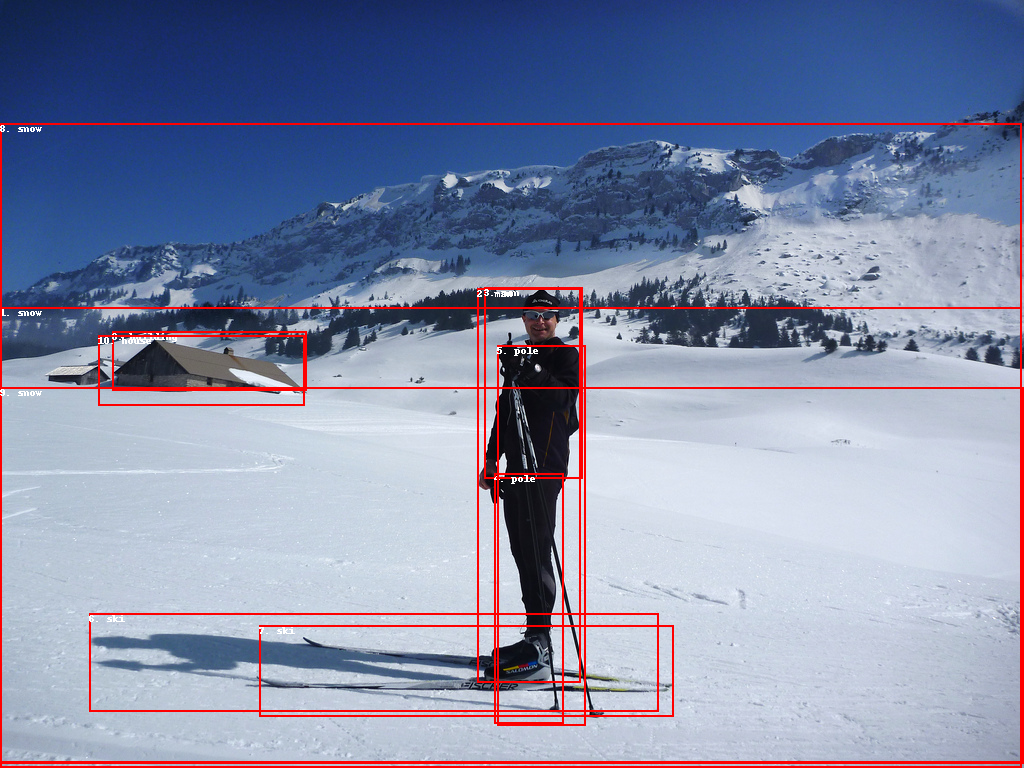

In [19]:
index = 1011
show_relation_info(index)
show_image_all(index)

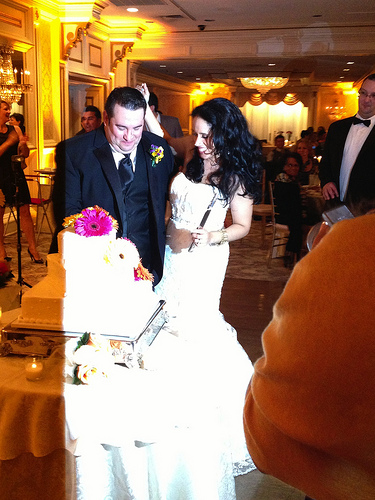

In [ ]:
Image.open(train_data.filenames[index]).convert("RGB")

In [ ]:
labels = train_data.gt_classes[index]
print([ predicate_dict['idx_to_label'][str(e)] for e in labels ])
for (s,o,p) in train_data.relationships[index]:
    print("(s, p, o) : ", predicate_dict['idx_to_label'][str(labels[s])], predicate_dict['idx_to_predicate'][str(p)], predicate_dict['idx_to_label'][str(labels[o])] )
print( train_data.get_img_info(index)['url'])

['building', 'bus', 'door', 'door', 'handle', 'sign', 'tire', 'tire', 'window', 'window', 'windshield']
(s, p, o) :  windshield in front of bus
(s, p, o) :  bus has door
(s, p, o) :  door to bus
(s, p, o) :  window near bus
(s, p, o) :  tire under bus
(s, p, o) :  handle on door
(s, p, o) :  window near building
(s, p, o) :  windshield on bus
https://cs.stanford.edu/people/rak248/VG_100K_2/2392079.jpg


In [ ]:
nobj = 150
n_images = 100000
excluded_idx = [] #[22, 136, 145]
# building : 22, man : 78, people : 91, shirt : 111, tree : 136, window : 145


def minus1(e):
    return e-1

def array2vec(arr):
    v = np.zeros(nobj)
    for e in arr:
        v[e-1] = 1
    return v

excluded_idx = list(map(minus1, excluded_idx))

clsvec = list(map(array2vec, train_data.gt_classes[:n_images]))
clsarr = np.array(clsvec)
clsarr = np.delete(clsarr, excluded_idx, axis=1)
clsvec = clsarr.tolist()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

x = StandardScaler().fit_transform(clsvec)
pca = PCA(n_components=20)
#reducer = umap.UMAP(n_components=7)
x = pca.fit_transform(x)
#x = reducer.fit_transform(x)
df = pd.DataFrame(data = x)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import hdbscan

def addsuffix(num):
    cond = len(str(num)) == 1
    return str(num) + '*' if cond else str(num) + "_"

k = 12

model = KMeans(n_clusters=k)
#model = GaussianMixture(n_components=k)
#model = DBSCAN(eps=0.5, min_samples=30)
#model = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True)

df['cluster'] = model.fit_predict(x)
#df['cluster'] = list(map(addsuffix, df['cluster']))
df.head()

/home/users/jaehyeong/.conda/envs/pysgg/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,cluster
0,1.157109,0.943926,-0.454645,-0.161853,-0.529680,0.782970,0.123849,-0.679715,0.355075,0.041296,...,-0.542922,-0.416163,0.211766,1.250129,0.514850,0.715037,-2.011248,-0.793061,-0.348865,9
1,-1.606997,-3.413494,-1.686727,-1.550256,0.485647,0.208197,-0.193803,0.142721,0.271328,-0.807081,...,0.682970,-0.914309,-0.496689,-0.053984,-0.787055,-0.327355,1.042819,-0.284201,0.207851,11
2,-1.687673,-2.257619,-0.657349,-0.752519,-0.267391,0.559246,-0.171337,0.711783,0.209988,1.881066,...,0.195128,0.262815,-0.742484,0.562406,0.513349,0.263875,-0.004849,-0.309811,-1.286417,11
3,0.152351,2.978173,0.286970,-0.654767,-1.011738,2.463153,-0.597859,0.364812,-0.285562,0.773378,...,-1.358441,-0.586682,0.580320,-0.692429,-0.099852,-0.939710,-0.179903,3.668047,-1.604542,9
4,-1.539308,-2.817684,0.313209,1.118771,-0.922999,-0.306253,1.499323,-0.027838,-0.670069,-2.202911,...,-1.738174,1.286904,0.814129,-0.232791,-0.310678,-0.115027,-0.353780,-0.332584,0.305583,7


In [ ]:
df.iloc[:,:-1].to_csv('feature.csv', sep='\t', header=False, index=False)
df.iloc[:,-1].to_csv('cluster.csv', sep='\t', header=False, index=False)

In [ ]:
labels = train_data.gt_classes[index]
print([ predicate_dict['idx_to_label'][str(e)] for e in labels ])
for (s,o,p) in train_data.relationships[index]:
    print("(s, p, o) : ", predicate_dict['idx_to_label'][str(labels[s])], predicate_dict['idx_to_predicate'][str(p)], predicate_dict['idx_to_label'][str(labels[o])] )
print( train_data.get_img_info(index)['url'])

['building', 'bus', 'door', 'door', 'handle', 'sign', 'tire', 'tire', 'window', 'window', 'windshield']
(s, p, o) :  windshield in front of bus
(s, p, o) :  bus has door
(s, p, o) :  door to bus
(s, p, o) :  window near bus
(s, p, o) :  tire under bus
(s, p, o) :  handle on door
(s, p, o) :  window near building
(s, p, o) :  windshield on bus
https://cs.stanford.edu/people/rak248/VG_100K_2/2392079.jpg


In [ ]:
# get images from each cluster
for cls in range(-1, k):
    print("cluster ", cls, "th image examples and ", "len : ", len(df[df['cluster'] == cls].index))
    count = 0
    for idx in df[df['cluster'] == cls].index:
        labels = train_data.gt_classes[idx]
        url = train_data.get_img_info(idx)['url']
        print("idx : ", idx, "url : ", url)
        print("object category : ", [ cat_dicts['idx_to_label'][str(e)] for e in labels ] )
        #print("image vector : ", x[idx])
        count += 1
        if count == 30: break
    print("\n\n\n\n\n\n")

cluster  -1 th image examples and  len :  0







cluster  0 th image examples and  len :  2245
idx :  72 url :  https://cs.stanford.edu/people/rak248/VG_100K/61579.jpg
object category :  ['coat', 'face', 'track', 'pole', 'pole', 'skier', 'ski', 'tree', 'tree', 'tree', 'woman', 'glove', 'snow', 'snow', 'snow', 'snow', 'ski', 'pole', 'woman', 'pole', 'hand']
idx :  92 url :  https://cs.stanford.edu/people/rak248/VG_100K/61599.jpg
object category :  ['arm', 'snow', 'skateboard', 'snow', 'track', 'track', 'track', 'track', 'kid', 'person', 'snow', 'skier', 'hill', 'person', 'snow', 'snow', 'helmet', 'man', 'person', 'snow', 'jacket', 'man', 'snow', 'helmet', 'snow', 'snow', 'shoe']
idx :  93 url :  https://cs.stanford.edu/people/rak248/VG_100K/61600.jpg
object category :  ['man', 'pole', 'ski', 'snow', 'tree']
idx :  103 url :  https://cs.stanford.edu/people/rak248/VG_100K/107899.jpg
object category :  ['arm', 'boot', 'building', 'fence', 'head', 'helmet', 'jacket', 'man', 'roof', 'shoe'

In [ ]:
# get specific cluster's statistic dictionary
object_count = {i:0 for i in cat_dicts['idx_to_label'].values()}
predicate_count = {i:0 for i in predicate_dict['idx_to_predicate'].values()}
cls = 3
show_pred = 'walking on'
print("cluster ", cls, "th image examples and ", "len : ", len(df[df['cluster'] == cls].index))
for idx in df[df['cluster'] == cls].index:
    labels = train_data.gt_classes[idx]
    exist = False
    for e in labels:
        object_count[ predicate_dict['idx_to_label'][str(e)] ] += 1
    for (s,o,p) in train_data.relationships[idx]:
        (ss, pp, oo) = predicate_dict['idx_to_label'][str(labels[s])], predicate_dict['idx_to_predicate'][str(p)], predicate_dict['idx_to_label'][str(labels[o])]
        predicate_count[ predicate_dict['idx_to_predicate'][str(p)] ] += 1
        if predicate_dict['idx_to_predicate'][str(p)] == show_pred:
            exist = True
        #print("s, o, p : ", (ss,oo,pp))
    if exist:
        print("idx", idx, "image : ", train_data.get_img_info(idx)['url'])
        #print("s, p, o : ", ss, pp, oo)
        
head_class = ['on', 'has', 'wearing', 'of', 'in', 'near', 'behind']
for pre in head_class:
    del predicate_count[pre]


cluster  3 th image examples and  len :  8029
idx 360 image :  https://cs.stanford.edu/people/rak248/VG_100K/150417.jpg
idx 432 image :  https://cs.stanford.edu/people/rak248/VG_100K/150491.jpg
idx 467 image :  https://cs.stanford.edu/people/rak248/VG_100K/150528.jpg
idx 580 image :  https://cs.stanford.edu/people/rak248/VG_100K/285687.jpg
idx 760 image :  https://cs.stanford.edu/people/rak248/VG_100K/285870.jpg
idx 958 image :  https://cs.stanford.edu/people/rak248/VG_100K/286074.jpg
idx 1021 image :  https://cs.stanford.edu/people/rak248/VG_100K/497948.jpg
idx 1056 image :  https://cs.stanford.edu/people/rak248/VG_100K/497985.jpg
idx 1081 image :  https://cs.stanford.edu/people/rak248/VG_100K/498010.jpg
idx 1297 image :  https://cs.stanford.edu/people/rak248/VG_100K/498233.jpg
idx 1430 image :  https://cs.stanford.edu/people/rak248/VG_100K/498370.jpg
idx 1448 image :  https://cs.stanford.edu/people/rak248/VG_100K/498388.jpg
idx 1633 image :  https://cs.stanford.edu/people/rak248/VG_1

xname :  43
yval :  43


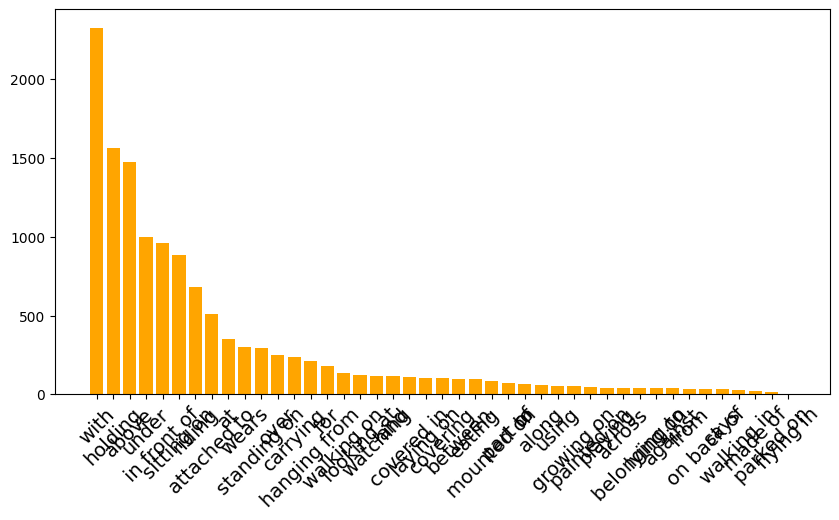

In [ ]:
# predicate statistic
predicate_count_sort = dict(sorted(predicate_count.items(), key=lambda k:k[1], reverse=True))
plt.figure(figsize=(10,5))
n_show = 100
x_name = list(predicate_count_sort.keys())[:n_show]
print("xname : ", len(x_name))
y_val = list(predicate_count_sort.values())[:n_show]
print("yval : ", len(y_val))
x_axis = np.arange(len(x_name))[:n_show]
plt.bar(x_axis, y_val, color='orange')
plt.xticks(x_axis, x_name, rotation=45)
plt.tick_params(axis='x', labelsize=14)
plt.show()

In [ ]:
predicate_count_sort.keys()

dict_keys(['with', 'holding', 'above', 'under', 'in front of', 'sitting on', 'riding', 'attached to', 'at', 'wears', 'standing on', 'over', 'carrying', 'hanging from', 'for', 'walking on', 'looking at', 'watching', 'and', 'covered in', 'laying on', 'covering', 'between', 'eating', 'mounted on', 'part of', 'to', 'along', 'using', 'growing on', 'painted on', 'playing', 'across', 'belonging to', 'lying on', 'against', 'from', 'on back of', 'says', 'walking in', 'made of', 'parked on', 'flying in'])

xname :  20
yval :  20


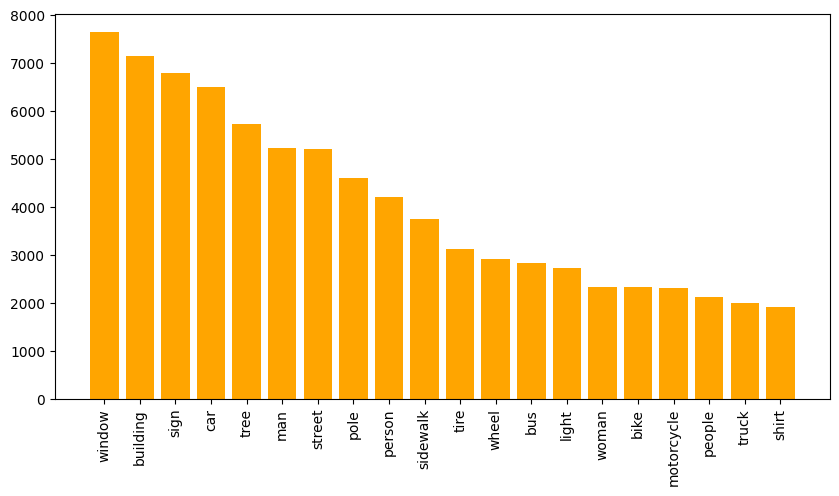

: 

In [ ]:
# object statistic
object_count_sort = dict(sorted(object_count.items(), key=lambda k:k[1], reverse=True))
plt.figure(figsize=(10,5))
n_show = 20
x_name = list(object_count_sort.keys())[:n_show]
print("xname : ", len(x_name))
y_val = list(object_count_sort.values())[:n_show]
print("yval : ", len(y_val))
x_axis = np.arange(len(x_name))[:n_show]
plt.bar(x_axis, y_val, color='orange')
plt.xticks(x_axis, x_name, rotation=90)
plt.show()

In [ ]:
object_count_sort.keys()

dict_keys(['man', 'shirt', 'person', 'woman', 'shoe', 'hair', 'hand', 'pant', 'tree', 'head', 'short', 'leg', 'hat', 'arm', 'boy', 'people', 'player', 'fence', 'jean', 'skateboard', 'jacket', 'building', 'girl', 'helmet', 'sock', 'window', 'bag', 'sign', 'racket', 'cap', 'pole', 'face', 'glass', 'chair', 'glove', 'sneaker', 'umbrella', 'bench', 'wheel', 'table', 'child', 'logo', 'sidewalk', 'leaf', 'car', 'tie', 'handle', 'light', 'guy', 'coat', 'door', 'horse', 'men', 'letter', 'kid', 'lady', 'street', 'seat', 'kite', 'bottle', 'stand', 'number', 'board', 'boot', 'phone', 'railing', 'flower', 'box', 'finger', 'house', 'ear', 'dog', 'neck', 'plate', 'flag', 'roof', 'post', 'plant', 'bike', 'tile', 'trunk', 'tail', 'banana', 'paper', 'elephant', 'boat', 'shelf', 'truck', 'branch', 'cup', 'book', 'rock', 'basket', 'beach', 'nose', 'hill', 'tire', 'motorcycle', 'sheep', 'laptop', 'wire', 'mountain', 'snow', 'curtain', 'towel', 'bear', 'cow', 'clock', 'screen', 'vehicle', 'mouth', 'pot', '